# Experiments using classifiers to evaluate teh affectivness of the models

## Section A - Dataset configuration

In [1]:
import numpy as np 
import kagglehub

pathA = kagglehub.dataset_download("dextershepherd/3d-texture-gel-tactip")
print(pathA)


/its/home/drs25/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.62G/2.62G [01:17<00:00, 36.5MB/s]

Extracting files...


/its/home/drs25/.cache/kagglehub/datasets/dextershepherd/3d-texture-gel-tactip/versions/2


In [2]:
import subprocess
result = subprocess.run(["mv", pathA, "/mnt/data0/drs25/data/3d/"], capture_output=True, text=True)
pathA="/mnt/data0/drs25/data/3d/"

### create lienar data

In [1]:
datapath="/mnt/data0/drs25/data/3d/2/"
import os 
import pandas as pd 
import numpy as np
import cv2 
files=os.listdir(datapath)
dataset= pd.DataFrame({
    'Index':[],
    'Filament':[],
    'Pattern':[],
    'Printer':[],
    "Pressure":[]
})
X=[]
idx=0
percentage=0.4
for i,file in enumerate(files):
    data=np.load(datapath+"/"+file)
    info=file.replace(".npy","").split("_")
    data=data.reshape((1*2*5*5,480,640,3))
    print(file,data.shape)
    for image in data:
        gray = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
        h=int(image.shape[0]*percentage)
        w=int(image.shape[1]*percentage)
        gray = cv2.resize(gray,(w,h),interpolation=cv2.INTER_AREA)
        X.append(gray)
        new_row = pd.DataFrame([{
        'Index': int(idx),
        'Filament': info[0],
        'Pattern': info[1],
        'Printer': info[3],
        'Pressure': info[2]
    }])
        idx+=1
        dataset = pd.concat([dataset, new_row], ignore_index=True)

dataset.head()
X=np.array(X).reshape(len(X),1,h,w)
np.save("/mnt/data0/drs25/data/optical-tactile-dataset-for-textures/3DPrintedXgel",X)
dataset.to_csv("/its/home/drs25/3D-textures/Experimental/data/metagel.csv")
print(X.shape,len(dataset))

PLAminus_z0_P30_Bambu.npy (50, 480, 640, 3)
PLAminus_z0_P30_Ender.npy (50, 480, 640, 3)
PLAminus_z0_P30_crealty.npy (50, 480, 640, 3)
PLAminus_z0_P40_Bambu.npy (50, 480, 640, 3)
PLAminus_z0_P40_Ender.npy (50, 480, 640, 3)
PLAminus_z0_P40_crealty.npy (50, 480, 640, 3)
PLAminus_z1_P30_Bambu.npy (50, 480, 640, 3)
PLAminus_z1_P30_Ender.npy (50, 480, 640, 3)
PLAminus_z1_P30_crealty.npy (50, 480, 640, 3)
PLAminus_z1_P40_Bambu.npy (50, 480, 640, 3)
PLAminus_z1_P40_Ender.npy (50, 480, 640, 3)
PLAminus_z1_P40_crealty.npy (50, 480, 640, 3)
PLAminus_z2_P30_Bambu.npy (50, 480, 640, 3)
PLAminus_z2_P30_Ender.npy (50, 480, 640, 3)


KeyboardInterrupt: 

### create file specific

In [ ]:
datapath="/mnt/data0/drs25/data/3d/2/"
import os
import pandas as pd
import numpy as np
import cv2

files = os.listdir(datapath)

dataset = pd.DataFrame({
    'Index': [],
    'Filament': [],
    'Pattern': [],
    'Printer': [],
    "Pressure": []
})

X = []
percentage = 0.4
idx = 0

for i, file in enumerate(files):
    data = np.load(os.path.join(datapath, file))
    info = file.replace(".npy", "").split("_")

    # reshape into (2, 5, 5, h, w, c)
    data = data.reshape((2, 5, 5, 480, 640, 3))
    print(file, data.shape)

    # resize each image and rebuild structure
    resized_block = np.zeros((2, 5, 5,
                              int(480 * percentage),
                              int(640 * percentage)),
                              dtype=np.float32)

    for a in range(2):
        for b in range(5):
            for c in range(5):
                image = data[a, b, c]
                gray = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
                h = int(gray.shape[0] * percentage)
                w = int(gray.shape[1] * percentage)
                gray = cv2.resize(gray, (w, h), interpolation=cv2.INTER_AREA)
                resized_block[a, b, c] = gray

    X.append(resized_block)

    new_row = pd.DataFrame([{
        'Index': int(idx),
        'Filament': info[0],
        'Pattern': info[1],
        'Printer': info[3],
        'Pressure': info[2]
    }])
    dataset = pd.concat([dataset, new_row], ignore_index=True)
    idx += 1

X = np.array(X).reshape((len(X)*2,5*5,h,w))  # final shape: (num_files, 2, 5, 5, h, w)
print("Final dataset shape:", X.shape)

np.save("/mnt/data0/drs25/data/optical-tactile-dataset-for-textures/3DPrintedXgelfs.npy", X)
dataset.to_csv("/its/home/drs25/3D-textures/Experimental/data/metagelfs.csv", index=False)


In [4]:
dataset.head()

Index  Filament Pattern Printer Pressure
0    0.0  PLAminus      z0   Bambu      P30
1    1.0  PLAminus      z0   Bambu      P30
2    2.0  PLAminus      z0   Bambu      P30
3    3.0  PLAminus      z0   Bambu      P30
4    4.0  PLAminus      z0   Bambu      P30

## Section B - modelling

In [1]:
import pandas as pd
import numpy as np
X=np.load("/mnt/data0/drs25/data/optical-tactile-dataset-for-textures/3DPrintedXgel.npy")
dataset=pd.read_csv("/its/home/drs25/3D-textures/Experimental/data/metagel.csv")
print("Dataset size:",X.shape)
print(len(dataset['Filament'].unique()),len(dataset['Printer'].unique()))
dataset.head()

Dataset size: (5000, 1, 192, 256)
4 5


Unnamed: 0  Index  Filament Pattern Printer Pressure
0           0    0.0  PLAminus      z0   Bambu      P30
1           1    1.0  PLAminus      z0   Bambu      P30
2           2    2.0  PLAminus      z0   Bambu      P30
3           3    3.0  PLAminus      z0   Bambu      P30
4           4    4.0  PLAminus      z0   Bambu      P30

In [229]:
dataset['Printer'].unique()

array(['Ender'], dtype=object)

### Prediction across classes

In [11]:

import cv2
def getsubset(filament, printer, dataset, X, augment=False,sobel=False,blur=False,pressure=-1,percentage=1):
    subset = dataset[(dataset['Filament'] == filament) & (dataset['Printer'] == printer)]
    subX, y = [], []
    for _, row in subset.iterrows():
        if pressure==-1 or row['Pressure']==pressure:
            y.append(int(row['Pattern'].replace("z", "")))

            # Extract ROI
            rois = X[int(row['Index'])]
            X_m=[]
            for roi in rois:
                roi=roi[25:175,50:200]
                if sobel:
                    # Apply Sobel filter (on grayscale if not already)
                    if roi.ndim == 3:  # convert to grayscale if it's RGB
                        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                    else:
                        roi_gray = roi

                    sobelx = cv2.Sobel(roi_gray, cv2.CV_64F, 1, 0, ksize=3)
                    sobely = cv2.Sobel(roi_gray, cv2.CV_64F, 0, 1, ksize=3)

                    sobel_ = np.hypot(sobelx, sobely)  # magnitude
                    sobel_ = cv2.convertScaleAbs(sobel_)  # scale back to uint8
                    roi=sobel_
                if blur:
                    roi = cv2.blur(roi,(3,3))
                if percentage!=1:
                    h = int(roi.shape[0] * percentage)
                    w = int(roi.shape[1] * percentage)
                    roi = cv2.resize(roi, (w, h), interpolation=cv2.INTER_AREA)
                X_m.append(roi)
            subX.append(X_m)
    if len(subX)!=0:
        y=np.array(y)
        subX=np.array(subX)
        mask = np.any(subX != 0, axis=(1,2,3))
        subX = subX[mask]
        y = y[mask]
        if augment:
            noisy=subX+np.random.normal(0,5,subX.shape)
            light=subX-10
            dark=subX+10
            light[light<0]=0
            dark[dark>255]=255
            subX=np.concatenate([subX,noisy,light,dark])
            y=np.concatenate([y,y,y,y])
    return subX,y 

subX,y=getsubset("PLAplus","Ender",dataset,X)
print(subX.shape)

(600, 1, 150, 150)


(12, 25, 150, 150)


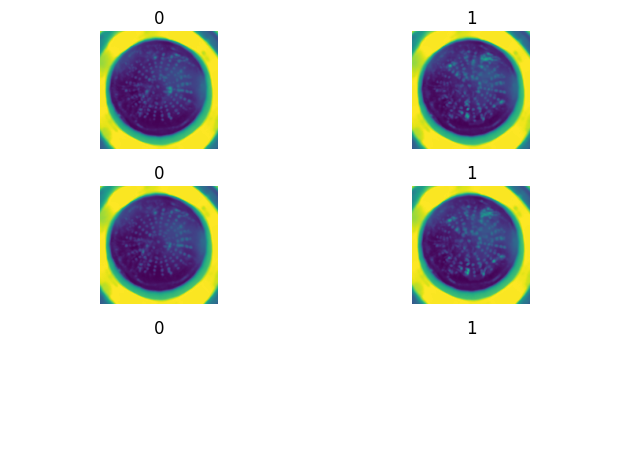

In [6]:
import matplotlib.pyplot as plt 
subX,y=getsubset("PLAplus","Ender",dataset,X)
print(subX.shape)
plt.subplot(3,2,1)
plt.imshow(subX[0][1])
plt.title(y[0])
plt.axis("off")

plt.subplot(3,2,2)
plt.imshow(subX[2][1])
plt.title(y[2])
plt.axis("off")

subX,y=getsubset("PLAminus","Ender",dataset,X)
plt.subplot(3,2,3)
plt.imshow(subX[0][1])
plt.title(y[0])
plt.axis("off")

plt.subplot(3,2,4)
plt.imshow(subX[2][1])
plt.title(y[2])
plt.axis("off")

subX,y=getsubset("PLAminus","Ender",dataset,X)
plt.subplot(3,2,5)
plt.title(subX[0][1])
plt.title(y[0])
plt.axis("off")

plt.subplot(3,2,6)
plt.title(subX[2][1])
plt.title(y[2])
plt.axis("off")
plt.tight_layout()
plt.show()

##### PCA

(500, 1, 150, 150)
(600, 1, 150, 150)
(600, 1, 150, 150)
(500, 1, 150, 150)
(600, 1, 150, 150)
(600, 1, 150, 150)
(500, 1, 150, 150)
(600, 1, 150, 150)
(500, 1, 150, 150)


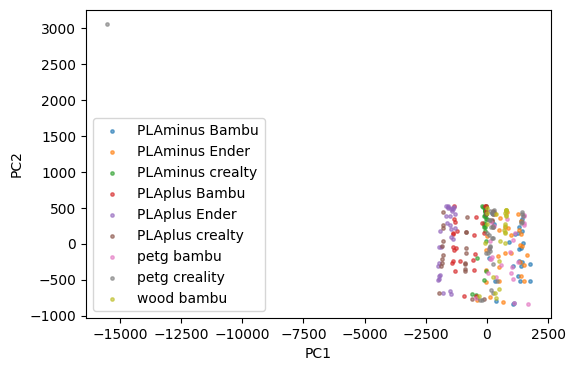

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
unique_filament = dataset["Filament"].unique()
unique_printer = dataset["Printer"].unique()
X_ = np.array([])
for filament in unique_filament:
    for printer in unique_printer:
        subX,y=getsubset(filament,printer,dataset,X)
        if len(subX)>0:
            print(subX.shape)
            if len(X_)==0: X_=subX.copy().reshape(len(subX),-1)
            else: X_ = np.vstack([X_,subX.reshape(len(subX),-1)])
        

pca = PCA(n_components=2).fit(X_)
Z = pca.transform(X_)  # (N,3)
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
rolling_length=0
for filament in unique_filament:
    for printer in unique_printer:
        subX,y=getsubset(filament,printer,dataset,X,pressure="P40")
        if len(subX)>0:
            Zs = Z[rolling_length:rolling_length+len(subX)]
            
            rolling_length+=len(subX)
            ax.scatter(Zs[::10,0], Zs[::10,1], label=filament+" "+printer, s=6, alpha=0.6)

ax.legend(); ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
plt.show()

#### ML

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

##### RFC PCA

In [5]:
def coral_align_target_to_source(Xs, Xt, eps=1e-6):
    """
    Align target Xt to source Xs distribution (target -> source).
    Xs, Xt: (N, D) feature arrays (float)
    Returns Xt_aligned with same mean as Xs and covariance aligned to Xs.
    """
    # center
    mu_s = Xs.mean(axis=0, keepdims=True)
    mu_t = Xt.mean(axis=0, keepdims=True)
    Xs_c = Xs - mu_s
    Xt_c = Xt - mu_t

    # covariances with small ridge
    cov_s = np.cov(Xs_c, rowvar=False) + np.eye(Xs_c.shape[1]) * eps
    cov_t = np.cov(Xt_c, rowvar=False) + np.eye(Xt_c.shape[1]) * eps

    # matrix square-roots via SVD
    Us, Ss, _ = np.linalg.svd(cov_s)
    Ut, St, _ = np.linalg.svd(cov_t)
    # cov_s^{1/2} and cov_t^{-1/2}
    cov_s_sqrt = Us @ np.diag(np.sqrt(Ss)) @ Us.T
    cov_t_inv_sqrt = Ut @ np.diag(1.0/np.sqrt(St)) @ Ut.T

    # transform target: Xt_aligned = (Xt_c @ cov_t^{-1/2}) @ cov_s^{1/2} + mu_s
    Xt_aligned = (Xt_c @ cov_t_inv_sqrt) @ cov_s_sqrt + mu_s
    return Xt_aligned

In [6]:
subX,y=getsubset("PLAplus","Ender",dataset,X,augment=1)
pca = PCA(n_components=25)
train_X, test_X, train_y, test_y = train_test_split(subX.reshape((len(subX),-1)), y, test_size=0.2, random_state=np.random.randint(0,100))
train_X= pca.fit_transform(train_X.reshape(len(train_X), -1))
test_X = pca.transform(test_X)
acc=np.zeros((20))
for i in range(20):
    clf = RandomForestClassifier(max_depth=50, random_state=np.random.randint(0,100))
    clf.fit(train_X, train_y)
    y_pred = clf.predict(test_X)
    accuracy = accuracy_score(test_y, y_pred)
    #print("Test",accuracy * 100, "%")
    y_pred = clf.predict(train_X)
    accuracy = accuracy_score(train_y, y_pred)
    #print("Train",accuracy * 100, "%")
    subX,y=getsubset("PLAminus","Ender",dataset,X)
    subX = pca.transform(subX.reshape((len(subX),-1)))
    #subX_aligned=coral_align_target_to_source(train_X.copy(), subX.copy())
    y_pred = clf.predict(subX)
    accuracy = accuracy_score(y, y_pred)
    #print("Other filament",accuracy * 100, "%")
    acc[i]=accuracy*100
print("Test",np.mean(acc), "%",np.std(acc))

Test 31.4 % 1.978635893740938


##### class predictions

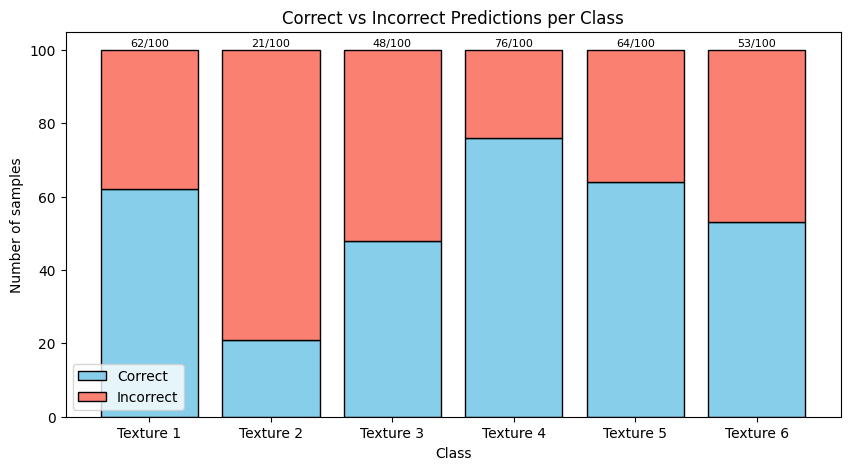

In [57]:
cm = confusion_matrix(y, y_pred, labels=np.unique(y))
class_labels = ["Texture "+str(i+1) for i in np.unique(y)]

correct_counts = cm.diagonal()
total_counts = cm.sum(axis=1)
incorrect_counts = total_counts - correct_counts

# --- stacked bar plot ---
plt.figure(figsize=(10,5))
bars_correct = plt.bar(class_labels, correct_counts, label="Correct", color="skyblue", edgecolor="black")
bars_incorrect = plt.bar(class_labels, incorrect_counts, bottom=correct_counts, 
                         label="Incorrect", color="salmon", edgecolor="black")

plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Correct vs Incorrect Predictions per Class")
plt.legend()

# annotate total counts above bars
for i, (c, ic, tot) in enumerate(zip(correct_counts, incorrect_counts, total_counts)):
    plt.text(i, tot+0.5, f"{c}/{tot}", ha="center", va="bottom", fontsize=8)

plt.show()

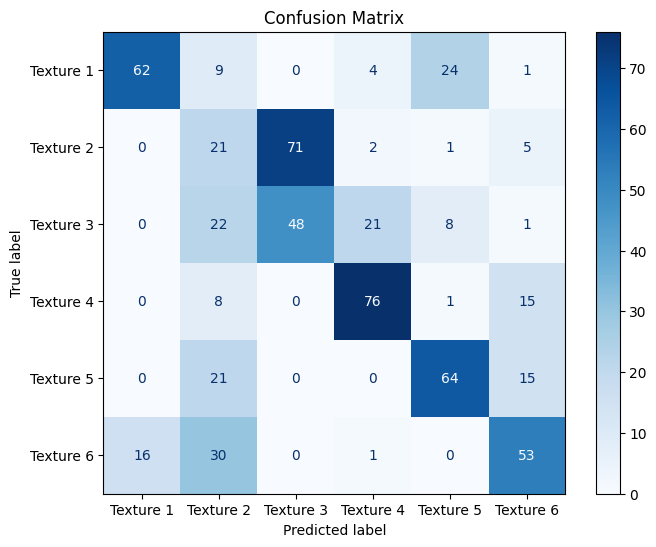

In [58]:
cm = confusion_matrix(y, y_pred, labels=np.unique(y))
class_labels = ["Texture "+str(i+1) for i in np.unique(y)]

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Confusion Matrix")
plt.savefig("/its/home/drs25/3D-textures/assets/confusion_RFC.pdf")
plt.show()

##### non pca

In [42]:
subX,y=getsubset("PLAplus","Ender",dataset,X)
train_X, test_X, train_y, test_y = train_test_split(subX.reshape((len(subX),-1)), y, test_size=0.2, random_state=np.random.randint(0,100))
clf = RandomForestClassifier(max_depth=50, random_state=0)
clf.fit(train_X, train_y)
y_pred = clf.predict(test_X)
accuracy = accuracy_score(test_y, y_pred)
print("Test",accuracy * 100, "%")
y_pred = clf.predict(train_X)
accuracy = accuracy_score(train_y, y_pred)
print("Train",accuracy * 100, "%")
subX,y=getsubset("PLAminus","Ender",dataset,X)
subX = subX.reshape((len(subX),-1))
y_pred = clf.predict(subX)
accuracy = accuracy_score(y, y_pred)
print("Other filament",accuracy * 100, "%")

Test 97.5 %
Train 100.0 %
Other filament 34.333333333333336 %


##### class predictions

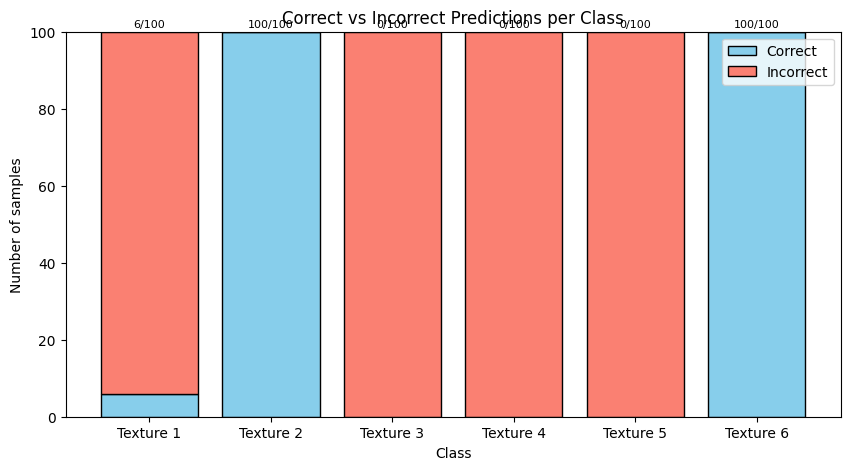

In [43]:
cm = confusion_matrix(y, y_pred, labels=np.unique(y))
class_labels = ["Texture "+str(i+1) for i in np.unique(y)]

correct_counts = cm.diagonal()
total_counts = cm.sum(axis=1)
incorrect_counts = total_counts - correct_counts

# --- stacked bar plot ---
plt.figure(figsize=(10,5))
bars_correct = plt.bar(class_labels, correct_counts, label="Correct", color="skyblue", edgecolor="black")
bars_incorrect = plt.bar(class_labels, incorrect_counts, bottom=correct_counts, 
                         label="Incorrect", color="salmon", edgecolor="black")

plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Correct vs Incorrect Predictions per Class")
plt.legend()

# annotate total counts above bars
for i, (c, ic, tot) in enumerate(zip(correct_counts, incorrect_counts, total_counts)):
    plt.text(i, tot+0.5, f"{c}/{tot}", ha="center", va="bottom", fontsize=8)

plt.show()

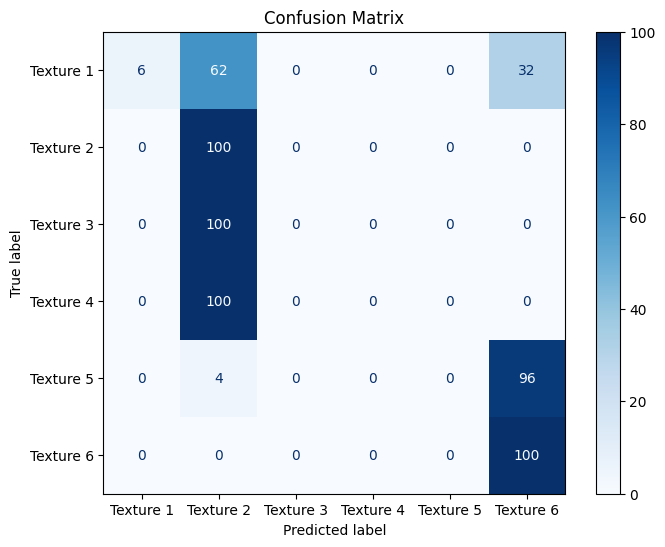

In [44]:
cm = confusion_matrix(y, y_pred, labels=np.unique(y))
class_labels = ["Texture "+str(i+1) for i in np.unique(y)]

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Confusion Matrix")
plt.show()

##### test robust

In [50]:
unique_filament = dataset["Filament"].unique()
unique_printer = dataset["Printer"].unique()
n = len(unique_filament) * len(unique_printer)
matrix = np.zeros((n, n, 20, 2))
torch.cuda.empty_cache()
num_classes = 6
n_idx = 0

for filament in unique_filament:
    for printer in unique_printer:
        train_X, train_y = getsubset(filament, printer, dataset, X,augment=1)
        pca = PCA(n_components=25)
        if len(train_X)>0:
            train_X= pca.fit_transform(train_X.reshape(len(train_X), -1))
            m_idx = 0
            for filament_other in unique_filament:
                for printer_other in unique_printer:
                    
                    if not (filament == filament_other and printer == printer_other):
                        test_X, test_y = getsubset(filament_other, printer_other, dataset, X)
                        if len(test_X)>0:
                            test_X = pca.transform(test_X.reshape(len(test_X), -1))
                            mean_train = train_X.mean(axis=0)
                            mean_other = test_X.mean(axis=0)
                            test_X = test_X - (mean_other - mean_train)
                            print(filament,printer,filament_other,printer_other,"\n\n",n_idx,m_idx,np.average(matrix),train_X.shape,train_y.shape,test_X.shape,test_y.shape)
                            for i in range(20):
                                clf = RandomForestClassifier(max_depth=50, random_state=np.random.randint(0,100))
                                clf.fit(train_X.reshape((len(train_X),-1)), train_y)
                                y_pred = clf.predict(test_X.reshape((len(test_X),-1)))
                                test_acc = accuracy_score(test_y, y_pred)
                                y_pred = clf.predict(train_X.reshape((len(train_X),-1)))
                                train_acc = accuracy_score(train_y, y_pred)
                                matrix[n_idx][m_idx][i][0] = test_acc
                                matrix[n_idx][m_idx][i][1] = train_acc
                                
                                gc.collect()
                            av=np.average(matrix[n_idx][m_idx],axis=0)
                            print(av[0]*100,"%",av[1]*100,"%")
                            np.save("/its/home/drs25/3D-textures/Experimental/data/matrix_RFC_gel.npy", matrix)
                            

                    m_idx += 1
            n_idx += 1


PLAminus Ender PLAplus Ender 

 0 1 0.0 (2400, 25) (2400,) (600, 25) (600,)
56.54999999999999 % 100.0 %
PLAplus Ender PLAminus Ender 

 1 0 0.19568750000000001 (2400, 25) (2400,) (600, 25) (600,)
61.441666666666684 % 100.0 %


#### NN

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import gc
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ------------------------------------------------------------------
# CNN definition with auto-calculated fc1 size
# ------------------------------------------------------------------
class CNN(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = None
        self.fc2 = None
        self.relu = nn.ReLU()

        # defer fc layer creation until we know final size
        self._dummy_init_done = False
        self.num_classes = num_classes

    def _init_fc(self, x):
        """Create fully connected layers once we know the feature size."""
        in_features = x.view(x.size(0), -1).shape[1]
        self.fc1 = nn.Linear(in_features, 128).to(x.device)
        self.fc2 = nn.Linear(128, 128).to(x.device)
        self.fc3 = nn.Linear(128, self.num_classes).to(x.device)
        self._dummy_init_done = True

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        if not self._dummy_init_done:
            self._init_fc(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleANN, self).__init__()
        # Input layer to hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Hidden layer to hidden layer (optional)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Hidden layer to output layer
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        # Apply ReLU activation for hidden layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # Output layer (no activation if using CrossEntropyLoss)
        x = self.fc3(x)
        return x
# ------------------------------------------------------------------
# Training routine (similar to testCNN)
# ------------------------------------------------------------------
def train_model(train_X, train_y, test_X, test_y, params, epochs=100, batch_size=32,arch=CNN,):
    # Permute to (N, C, H, W)
    if len(train_X.shape)>2:
        train_X = np.transpose(train_X, (0, 3, 1, 2))
        test_X = np.transpose(test_X, (0, 3, 1, 2))
        train_X=(np.max(train_X)-train_X)/(np.max(train_X)-np.min(train_X))
        test_X=(np.max(test_X)-test_X)/(np.max(test_X)-np.min(test_X))
    # Convert to torch tensors
    train_X = torch.tensor(train_X, dtype=torch.float32)
    test_X = torch.tensor(test_X, dtype=torch.float32)
    train_y = torch.tensor(train_y)
    test_y = torch.tensor(test_y)

    train_dataset = TensorDataset(train_X, train_y)
    test_dataset = TensorDataset(test_X, test_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = arch(*params).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(epochs):
        #model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            X_batch=X_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.to(device))
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()
        if epoch%20==0: print("Epoch",epoch," loss:",loss.item())

    # Evaluate
    def evaluate(loader):
        model.eval()
        correct, total, running_loss = 0, 0, 0.0
        with torch.no_grad():
            for X_batch, y_batch in loader:
                outputs = model(X_batch.to(device))
                loss = criterion(outputs, y_batch.to(device))
                running_loss += loss.item()
                predicted = torch.argmax(outputs.cpu(), axis=1)
                correct += (predicted == torch.argmax(y_batch, axis=1)).sum().item()
                total += y_batch.size(0)
        return running_loss / len(loader), correct / total

    test_loss, test_acc = evaluate(test_loader)
    train_loss, train_acc = evaluate(train_loader)
    return model, train_acc, test_acc

# ------------------------------------------------------------------
# Dataset splitting helpers
# ------------------------------------------------------------------


def get_y(y, num_classes):
    unique_labels = np.arange(num_classes)
    label_map = {label: i for i, label in enumerate(unique_labels)}
    y_mapped = np.array([label_map.get(l, -1) for l in y])
    y_cat = np.eye(num_classes)[y_mapped]
    return y_cat



##### CNN

In [12]:
unique_filament = dataset["Filament"].unique()
unique_printer = dataset["Printer"].unique()
print(len(unique_filament))
print(len(unique_printer))
a=[]
for filament in unique_filament:
    for printer in unique_printer:
        subX, y = getsubset(filament, printer, dataset, X, True)
        if len(subX)>1 and len(y)>1:
            y = get_y(y, 6)
            print(subX.shape,y.shape)
            train_X, test_X, train_y, test_y = train_test_split(subX.reshape((subX.shape[0],subX.shape[1]*subX.shape[2],subX.shape[3], 1)).astype('float32'), y, test_size=0.2, random_state=np.random.randint(0,100))

            model, train_acc, test_acc = train_model(
                                                train_X, train_y, test_X, test_y, (6, test_X.shape[-1]), epochs=200,batch_size=64,arch=CNN
                                            )
            torch.cuda.empty_cache()
            a.append([train_acc,test_acc])   

print(np.array(a))       
np.save("/its/home/drs25/3D-textures/Experimental/data/CNNTT",a)

4
5
(2000, 1, 150, 150) (2000, 6)
Epoch 0  loss: 1.7651196606457233
Epoch 20  loss: 1.615050794556737
Epoch 40  loss: 1.5998782459646463
Epoch 60  loss: 1.595609711483121
Epoch 80  loss: 1.556903863325715
Epoch 100  loss: 1.5690417643636465
Epoch 120  loss: 1.5387778598815203
Epoch 140  loss: 1.556550895795226
Epoch 160  loss: 1.5086302198469639
Epoch 180  loss: 1.4887585416436195
(2400, 1, 150, 150) (2400, 6)
Epoch 0  loss: 1.803011804819107
Epoch 20  loss: 1.7835798598825932
Epoch 40  loss: 1.754284031689167
Epoch 60  loss: 1.7585121486335993
Epoch 80  loss: 1.7039320804178715
Epoch 100  loss: 1.6376215405762196
Epoch 120  loss: 1.6682265903800726
Epoch 140  loss: 1.5427672863006592
Epoch 160  loss: 1.5498316138982773
Epoch 180  loss: 1.5266322176903486
(2400, 1, 150, 150) (2400, 6)
Epoch 0  loss: 1.7891770023852587
Epoch 20  loss: 1.7292521223425865
Epoch 40  loss: 1.6471190499141812
Epoch 60  loss: 1.575329750776291
Epoch 80  loss: 1.3571379943750799
Epoch 100  loss: 1.411799236666

In [16]:
import numpy as np
a=np.load("/its/home/drs25/3D-textures/Experimental/data/CNNTT.npy")
a.shape
print(np.average(a,axis=0))

[0.53664352 0.53046296]


In [81]:
# ------------------------------------------------------------------
# Main loop (similar to your Keras code)
# ------------------------------------------------------------------
unique_filament = dataset["Filament"].unique()
unique_printer = dataset["Printer"].unique()
n = len(unique_filament) * len(unique_printer)
matrix = np.zeros((n, n, 20, 2))
torch.cuda.empty_cache()
num_classes = 6
n_idx = 0
for filament in unique_filament:
    for printer in unique_printer:
        train_X, train_y = getsubset(filament, printer, dataset, X, True)
        if len(train_X)>0:
            train_y = get_y(train_y, num_classes)
            shape=train_X.shape
            train_X=train_X.reshape((shape[0],shape[1]*shape[2],shape[3], 1)).astype('float32')
            
            m_idx = 0
            for filament_other in unique_filament:
                for printer_other in unique_printer:
                    
                    if not (filament == filament_other and printer == printer_other):
                        test_X, test_y = getsubset(filament_other, printer_other, dataset, X)
                        if len(test_X)>0:
                            test_y = get_y(test_y, num_classes)
                            shape=test_X.shape
                            test_X = test_X.reshape((shape[0],shape[1]*shape[2],shape[3], 1)).astype('float32')
                            print(filament,printer,filament_other,printer_other,"\n\n",n_idx,m_idx,np.average(matrix),train_X.shape,train_y.shape,test_X.shape,test_y.shape)
                            for i in range(20):
                                model, train_acc, test_acc = train_model(
                                    train_X, train_y, test_X, test_y, (num_classes, test_X.shape[-1]), epochs=1500,batch_size=64,arch=CNN
                                )
                                torch.cuda.empty_cache()
                                print(test_acc*100,"%",train_acc*100,"%")
                                matrix[n_idx][m_idx][i][0] = test_acc
                                matrix[n_idx][m_idx][i][1] = train_acc
                                matrix[m_idx][n_idx][i][0] = test_acc
                                matrix[m_idx][n_idx][i][1] = train_acc

                                del model
                                gc.collect()
                                np.save("/its/home/drs25/3D-textures/Experimental/data/matrix_CNN_gel.npy", matrix)

                    m_idx += 1
            n_idx += 1


PLAminus Ender PLAplus Ender 

 0 1 0.0 (2400, 150, 150, 1) (2400, 6) (600, 150, 150, 1) (600, 6)
Epoch 0  loss: 1.7933131270110607
Epoch 20  loss: 1.764554787427187
Epoch 40  loss: 1.6782447136938572
Epoch 60  loss: 1.6449026484042406
Epoch 80  loss: 1.5830982699990273
Epoch 100  loss: 1.597213588654995
Epoch 120  loss: 1.4281967747956514
Epoch 140  loss: 1.319458395242691
Epoch 160  loss: 1.3036827007308602
Epoch 180  loss: 1.3662274647504091
28.000000000000004 % 58.791666666666664 %
Epoch 0  loss: 1.802685670554638
Epoch 20  loss: 1.7536925934255123
Epoch 40  loss: 1.7736788131296635
Epoch 60  loss: 1.5861762259155512
Epoch 80  loss: 1.48021699488163
Epoch 100  loss: 1.5772069953382015
Epoch 120  loss: 1.5240867603570223
Epoch 140  loss: 1.4452669443562627
Epoch 160  loss: 1.3635963574051857
Epoch 180  loss: 1.5933506768196821
32.666666666666664 % 54.58333333333333 %
Epoch 0  loss: 1.7973228357732296
Epoch 20  loss: 1.7879930287599564
Epoch 40  loss: 1.7492026425898075
Epoch 60  los

##### ANN

In [7]:
from sklearn.decomposition import PCA
unique_filament = dataset["Filament"].unique()
b=[]
for i in range(20):
    for filament in unique_filament:
            subX, y = getsubset(filament, 'Bambu', dataset, X, True)
            if len(subX)>1 and len(y)>1:
                y = get_y(y, 6)
                print(subX.shape,y.shape)
                train_X, test_X, train_y, test_y = train_test_split(subX.reshape((subX.shape[0],-1)).astype('float32'), y, test_size=0.2, random_state=np.random.randint(0,100))
                pca = PCA(n_components=20).fit(train_X)
                train_X= pca.fit_transform(train_X.reshape(len(train_X), -1))
                test_X = pca.transform(test_X.reshape(len(test_X), -1)).astype('float32')
                mean_train = train_X.mean(axis=0)
                mean_other = test_X.mean(axis=0)
                test_X = test_X - (mean_other - mean_train)
                model, train_acc, test_acc = model, train_acc, test_acc = train_model(
                                            train_X, train_y, test_X, test_y, (20,50,6), epochs=1500,batch_size=64, arch=SimpleANN
                                        )
                torch.cuda.empty_cache()
                b.append([train_acc,test_acc])   

b=np.array(b)
np.save("/its/home/drs25/3D-textures/Experimental/data/ANN_bambu",b)  
print(np.average(b,axis=0))  

(2000, 1, 150, 150) (2000, 6)
Epoch 0  loss: 2.169538852313657
Epoch 20  loss: 0.15957231913903402
Epoch 40  loss: 0.0008868060215025952
Epoch 60  loss: 0.00021941019246085602
Epoch 80  loss: 2.570379731170469e-05
Epoch 100  loss: 3.479929863736686e-05
Epoch 120  loss: 6.59653008583394e-05
Epoch 140  loss: 5.237381638523164e-05
Epoch 160  loss: 4.052212493754759e-05
Epoch 180  loss: 2.7844822023226357e-05
Epoch 200  loss: 1.653131116075013e-05
Epoch 220  loss: 2.5833615252990327e-05
Epoch 240  loss: 9.55098814803268e-06
Epoch 260  loss: 7.239852243379197e-06
Epoch 280  loss: 1.7384795005237486e-05
Epoch 300  loss: 1.4665073398645312e-05
Epoch 320  loss: 5.9024298212362325e-06
Epoch 340  loss: 4.127517102547884e-06
Epoch 360  loss: 2.073095732968433e-06
Epoch 380  loss: 4.235515071782103e-06
Epoch 400  loss: 3.3078833221455994e-06
Epoch 420  loss: 9.044113680078958e-06
Epoch 440  loss: 7.211043714927534e-06
Epoch 460  loss: 3.930148151365387e-07
Epoch 480  loss: 2.1028455290394987e-06
E

In [6]:
b

[[1.0, 0.9975], [1.0, 0.995]]

In [18]:
from sklearn.decomposition import PCA
unique_filament = dataset["Filament"].unique()
unique_printer = dataset["Printer"].unique()
b=[]
for filament in unique_filament:
    for printer in unique_printer:
        subX, y = getsubset(filament, printer, dataset, X, True)
        if len(subX)>1 and len(y)>1:
            y = get_y(y, 6)
            print(subX.shape,y.shape)
            train_X, test_X, train_y, test_y = train_test_split(subX.reshape((subX.shape[0],-1)).astype('float32'), y, test_size=0.2, random_state=np.random.randint(0,100))
            pca = PCA(n_components=20).fit(train_X)
            train_X= pca.fit_transform(train_X.reshape(len(train_X), -1))
            test_X = pca.transform(test_X.reshape(len(test_X), -1)).astype('float32')
            mean_train = train_X.mean(axis=0)
            mean_other = test_X.mean(axis=0)
            test_X = test_X - (mean_other - mean_train)
            model, train_acc, test_acc = model, train_acc, test_acc = train_model(
                                        train_X, train_y, test_X, test_y, (20,50,6), epochs=1500,batch_size=64, arch=SimpleANN
                                    )
            torch.cuda.empty_cache()
            b.append([train_acc,test_acc])   

print(np.array(b))  
np.save("/its/home/drs25/3D-textures/Experimental/data/ANNTT",b)     

(2000, 1, 150, 150) (2000, 6)
Epoch 0  loss: 3.3014530979979035
Epoch 20  loss: 0.0032337779935830424
Epoch 40  loss: 0.0006211502400873536
Epoch 60  loss: 0.14691381997194886
Epoch 80  loss: 0.00012340919384346005
(2400, 1, 150, 150) (2400, 6)
Epoch 0  loss: 1.601389432971974
Epoch 20  loss: 0.007260877601173554
Epoch 40  loss: 0.05252108290169477
Epoch 60  loss: 0.00031522040089015935
Epoch 80  loss: 9.246004204399583e-05
(2400, 1, 150, 150) (2400, 6)
Epoch 0  loss: 2.3254095149109077
Epoch 20  loss: 0.003934573415610654
Epoch 40  loss: 0.0004956395275016456
Epoch 60  loss: 0.00024891163796592064
Epoch 80  loss: 0.00035941022162788716
(2000, 1, 150, 150) (2000, 6)
Epoch 0  loss: 4.253498023370474
Epoch 20  loss: 0.003209479675686633
Epoch 40  loss: 0.002320364008801312
Epoch 60  loss: 0.0005477646988402141
Epoch 80  loss: 0.001344033433641978
(2400, 1, 150, 150) (2400, 6)
Epoch 0  loss: 3.8214756733895854
Epoch 20  loss: 0.07147840964313512
Epoch 40  loss: 0.09268168527569554
Epoch 6

###### resolution

In [24]:
filament="PLAminus"
printer="Bambu"
resolutions=np.arange(0.05,1,0.05)
results=np.zeros((len(resolutions),20,2))
for j,res in enumerate(resolutions):
    for i in range(20):
        subX, y = getsubset(filament, printer, dataset, X, True,percentage=res)
        y = get_y(y, 6)
        #make dataset
        train_X, test_X, train_y, test_y = train_test_split(subX.reshape((subX.shape[0],-1)).astype('float32'), y, test_size=0.2, random_state=np.random.randint(0,100))
        pca = PCA(n_components=20).fit(train_X)
        train_X= pca.fit_transform(train_X.reshape(len(train_X), -1))
        test_X = pca.transform(test_X.reshape(len(test_X), -1)).astype('float32')
        #train model
        mean_train = train_X.mean(axis=0)
        mean_other = test_X.mean(axis=0)
        test_X = test_X - (mean_other - mean_train)
        model, train_acc, test_acc = model, train_acc, test_acc = train_model(
                                    train_X, train_y, test_X, test_y, (20,50,6), epochs=1500,batch_size=64, arch=SimpleANN
                                    )
        #gather data
        print(train_acc,test_acc,results.shape)
        results[j][i][0]=train_acc
        results[j][i][1]=test_acc
np.save("/its/home/drs25/3D-textures/Experimental/data/resoutions_test",results)   
#save data
#plot data

Epoch 0  loss: 1.5780164021998644
Epoch 20  loss: 0.7548505624727113
Epoch 40  loss: 0.2934290163384219
Epoch 60  loss: 0.09987897389601119


In [7]:
import numpy as np
b=np.load("/its/home/drs25/3D-textures/Experimental/data/ANNTT.npy")     
np.average(b,axis=0)

array([0.99784722, 0.99388889])

In [5]:
# ------------------------------------------------------------------
# Main loop (similar to your Keras code)
# ------------------------------------------------------------------
unique_filament = dataset["Filament"].unique()
unique_printer = dataset["Printer"].unique()
n = len(unique_filament) * len(unique_printer)
matrix = np.zeros((n, n, 20, 2))
torch.cuda.empty_cache()
num_classes = 6
n_idx = 0
for filament in unique_filament:
    for printer in unique_printer:
        train_X, train_y = getsubset(filament, printer, dataset, X, True)
        pca = PCA(n_components=20)
        if len(train_X)>0:
            train_X= pca.fit_transform(train_X.reshape(len(train_X), -1))
            train_y = get_y(train_y, num_classes)
            m_idx = 0
            for filament_other in unique_filament:
                for printer_other in unique_printer:
                    
                    if not (filament == filament_other and printer == printer_other):
                        test_X, test_y = getsubset(filament_other, printer_other, dataset, X)
                        if len(test_X)>0:
                            test_X = pca.transform(test_X.reshape(len(test_X), -1)).astype('float32')
                            mean_train = train_X.mean(axis=0)
                            mean_other = test_X.mean(axis=0)
                            test_X = test_X - (mean_other - mean_train)
                            test_y = get_y(test_y, num_classes)
                            print(filament,printer,filament_other,printer_other,"\n\n",n_idx,m_idx,np.average(matrix),train_X.shape,train_y.shape,test_X.shape,test_y.shape)
                            for i in range(20):
                                model, train_acc, test_acc = train_model(
                                    train_X, train_y, test_X, test_y, (20,50,6), epochs=1500,batch_size=64, arch=SimpleANN
                                )
                                torch.cuda.empty_cache()
                                print(test_acc*100,"%",train_acc*100,"%")
                                matrix[n_idx][m_idx][i][0] = test_acc
                                matrix[n_idx][m_idx][i][1] = train_acc
                                
                                del model
                                gc.collect()
                                np.save("/its/home/drs25/3D-textures/Experimental/data/matrix_ann_gel_e1500.npy", matrix)

                    m_idx += 1
            n_idx += 1


PLAminus Bambu PLAminus Ender 

 0 1 0.0 (2000, 20) (2000, 6) (600, 20) (600, 6)
Epoch 0  loss: 2.5056449489520674
Epoch 20  loss: 0.002848174535891701
Epoch 40  loss: 0.0003375006979720041
Epoch 60  loss: 0.0011829093143083114
Epoch 80  loss: 5.676662853115744e-05
Epoch 100  loss: 0.0002832519129292166
Epoch 120  loss: 4.020823541583951e-05
Epoch 140  loss: 3.283919790497691e-05
Epoch 160  loss: 3.629879158939531e-05
Epoch 180  loss: 1.4252108391676899e-05
Epoch 200  loss: 1.1085679253675096e-05
Epoch 220  loss: 1.5944163607173323e-06
Epoch 240  loss: 3.878117027866779e-05
Epoch 260  loss: 8.270114175701337e-07
Epoch 280  loss: 1.303848072620184e-06
Epoch 300  loss: 5.513416199143251e-07
Epoch 320  loss: 5.215397029800783e-07
Epoch 340  loss: 4.254163616490558e-06
Epoch 360  loss: 1.2442387919975317e-06
Epoch 380  loss: 2.3841818030945205e-07
Epoch 400  loss: 2.8535491907177857e-06
Epoch 420  loss: 1.0207216933899588e-06
Epoch 440  loss: 1.0430806263173054e-07
Epoch 460  loss: 2.23517

In [6]:
matrix=np.load("/its/home/drs25/3D-textures/Experimental/data/matrix_ann_gel_e1500.npy")#"/its/home/drs25/3D-textures/Experimental/data/matrix_CNN_gel.npy")#
print(matrix.shape)
train=matrix[:,:,:,1].flatten()
test=matrix[:,:,:,0].flatten()
train=train[train != 0]
test=test[test != 0]
np.average(train).item(),np.average(test).item()

(20, 20, 20, 2)


(0.9998732060185186, 0.3321368176538908)

### Test all classes on pretrained models

## Section C - Visualise

In [8]:
matrix

array([[[[0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ],
         ...,
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.15777778, 0.42933333],
         [0.33333333, 0.392     ],
         [0.27222222, 0.53333333],
         ...,
         [0.22777778, 0.46933333],
         [0.16888889, 0.55866667],
         [0.32444444, 0.40933333]],

        [[0.08111111, 0.71333333],
         [0.01555556, 0.492     ],
         [0.21333333, 0.58666667],
         ...,
         [0.05333333, 0.50266667],
         [0.17666667, 0.46933333],
         [0.16666667, 0.36666667]],

        ...,

        [[0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ],
         ...,
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ],
         [0.

## Processing across the same one

In [1]:
import pandas as pd
import numpy as np
X=np.load("/mnt/data0/drs25/data/optical-tactile-dataset-for-textures/3DPrintedXgel.npy")
dataset=pd.read_csv("/its/home/drs25/3D-textures/Experimental/data/metagel.csv")
print("Dataset size:",X.shape,len(dataset))
dataset.head()


import cv2

z=dataset[(dataset['Pattern'] == "z5") & (dataset['Pressure'] == "P40")]
print(len(z))
z["Printer"] = z["Printer"].str.lower()  #normalize if needed
group_cols = ["Printer", "Filament"]
past=("none","none")
counter=0
d={}
for idx, row in z.iterrows():
    keys = tuple(row[c] for c in group_cols)
    if keys[0]!=past[0] or keys[1]!=keys[1]:
        counter=0
    if d.get(counter,False)!=False:
        d[counter].append(int(row['Index']))
    else:
        d[counter]=[int(row['Index'])]
    counter+=1
    past=keys



Dataset size: (5000, 1, 192, 256) 5000
250


/tmp/ipykernel_321121/1710354845.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z["Printer"] = z["Printer"].str.lower()  #normalize if needed


In [6]:
# look at variance
m=[]
for key in d:
    frames=d[key]
    vals=X[frames]
    vals=vals.reshape((len(vals),-1))
    pixel_var=np.var(vals, axis=0)
    mean_var = np.mean(pixel_var)
    #print(mean_var/5461 *100, "%")
    m.append(mean_var)
print(sum(m)/len(m))

123.12991403689895


In [5]:
# which ones have the most variance
ids=[]
for key in d:
    frames=d[key]
    vals=X[frames]
    vals=vals.reshape((len(vals),-1))
    m=[]
    for i in range(len(vals)):
        subset = np.delete(vals, i, axis=0)
        pixel_var=np.var(subset, axis=0)
        mean_var = np.mean(pixel_var)
        #print(mean_var/5461 *100, "%")
        #norm=mean_var/5461 *100
        m.append(mean_var)
    n=np.argmin(np.array(m))
    ids.append((frames[n],min(m)))
    
print("Classes ranked by variance from others:")

for c,_ in ids:
    vals=(z[z["Index"] == float(c)])
    filament=vals["Filament"].item()
    printer=vals["Printer"].item()
    if values.get(filament,False)!=False:
        values[filament]+=1
    else: values[filament]=1
    if values.get(printer,False)!=False:
        values[printer]+=1
    else: values[printer]=1

values

Classes ranked by variance from others:


NameError: name 'values' is not defined

In [113]:
a=[]
for i in values:
    a.append(values[i])

for i in values:
    print(i,values[i]/sum(a) *100,"%")

PLAplus 16.0 %
crealty 25.666666666666664 %
PLAminus 24.833333333333332 %
petg 9.166666666666666 %
bambu 12.5 %
ender 11.0 %
creality 0.8333333333333334 %
